Make environment

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Specify the path to the HDF5 file
input_file = "AEP_PSGC1_AMP_long.h5"  # Change this to the path of your HDF5 file

# Load data from HDF5 file
loaded_data = pd.read_hdf(input_file, key="data")


In [3]:
price_values_array = loaded_data.HE.values

In [4]:
price_values_array

array([25.88, 24.88, 23.45, ..., 22.81, 22.61, 22.25])

In [5]:
loaded_data

HE
MARKET_DAY NODE          TYPE    VALUE HourEnding       
2021-07-01 AEP.PSGC1.AMP Gennode LMP   1           25.88
                                       2           24.88
                                       3           23.45
                                       4           22.47
                                       5           21.73
...                                                  ...
2023-12-31 AEP.PSGC1.AMP Gennode LMP   20          25.23
                                       21          22.71
                                       22          22.81
                                       23          22.61
                                       24          22.25

[13176 rows x 1 columns]

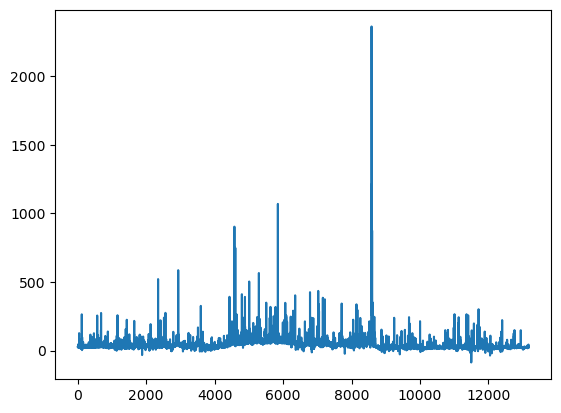

In [6]:
plt.plot(price_values_array)

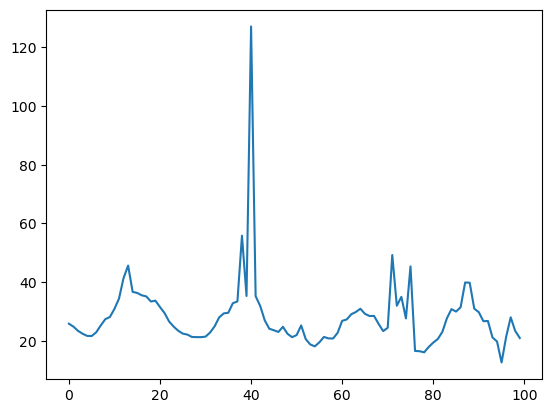

In [14]:
plt.plot(price_values_array[:100])

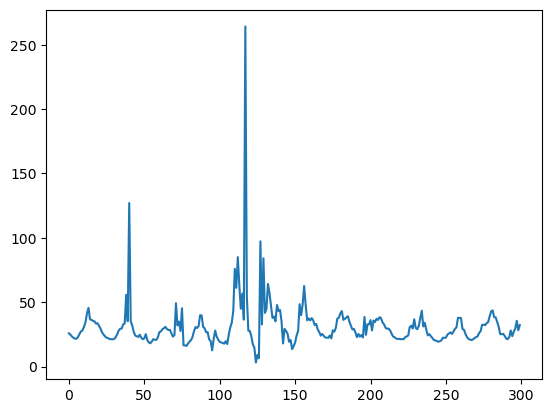

In [15]:
plt.plot(price_values_array[:300])

# Based on lab 7, Exercises 2, stock trading

In [20]:
import gym
from stable_baselines3.common.vec_env import DummyVecEnv 
from stable_baselines3 import A2C 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym_anytrading  # https://github.com/AminHP/gym-anytrading
from gym_anytrading.envs import StocksEnv
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override() # bug fix, for details see https://stackoverflow.com/questions/74862453/why-am-i-getting-a-typeerror-string-indices-must-be-integer-message-when-tryi
from ta import add_all_ta_features # Method from TA (Technical Analysis) library to engineer financial indicators

In [21]:
import gym_anytrading  # https://github.com/AminHP/gym-anytrading
from gym_anytrading.envs import StocksEnv
from stable_baselines3 import A2C 


checked github for gym_anytrading https://github.com/AminHP/gym-anytrading

Simplifies it to just buy and sell, no holding, only short and long

StocksEnv has transaction fees for bids and asks

Data is divided into Prices and signals/features

Is the short position an exposure of 0 or -1? we want it to be an exposure of 0

Do they account for the final position's value? We don't necessarily want to.

In [9]:
loaded_data.loc[:,'HE'] 
# HE is actually the price

MARKET_DAY  NODE           TYPE     VALUE  HourEnding
2021-07-01  AEP.PSGC1.AMP  Gennode  LMP    1             25.88
                                           2             24.88
                                           3             23.45
                                           4             22.47
                                           5             21.73
                                                         ...  
2023-12-31  AEP.PSGC1.AMP  Gennode  LMP    20            25.23
                                           21            22.71
                                           22            22.81
                                           23            22.61
                                           24            22.25
Name: HE, Length: 13176, dtype: float64

In [24]:
13176/24

549.0

In [27]:
30*24

720

In [10]:
def my_processed_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'HE'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['HE']].to_numpy()[start:end] # only has HE price
    return prices, signal_features

class MyCustomEnv(StocksEnv):
    _process_data = my_processed_data


In [11]:
env2 = MyCustomEnv(df=loaded_data, window_size= 24, frame_bound=(24, 720)) # window size 24 means see last 24?
# frame bound is start and end timesteps
print(env2.observation_space.shape)

(24, 1)


In [12]:
model = A2C('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=800)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 207       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.596    |
|    explained_variance | -1.19e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.0284   |
|    value_loss         | 0.137     |
-------------------------------------


In [13]:
720*2

1440

In [14]:
df2 = loaded_data

In [15]:
env = MyCustomEnv(df=loaded_data, window_size=24, frame_bound=(720, 1440))
obs = env.reset()
obs = obs[0]

while True:
    action, states = model.predict(obs)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        print(info)
        break

{'total_reward': -24.77999999999995, 'total_profit': 0.14055867720400667, 'position': <Positions.Short: 0>}


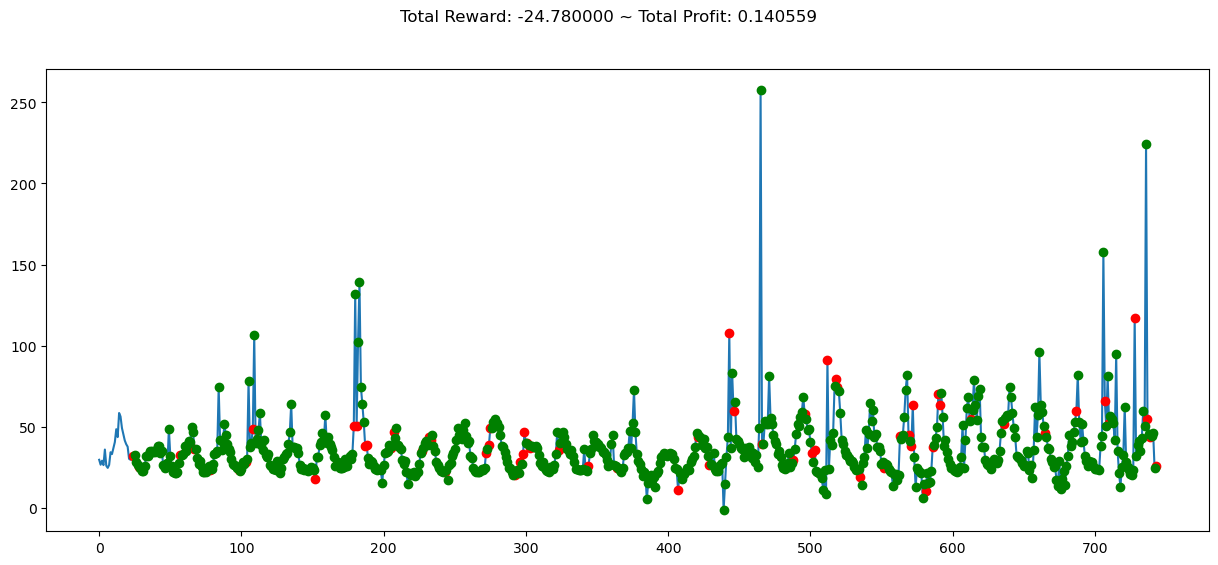

In [16]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()

https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/stocks_env.py

We should modify the stocks Env to be more like a battery/power environment

To me, seems like they don't go short

Also refer to TradingEnv https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py

Agent doesn't actually know state of battery/position long or short

Below is a copy of the StocksEnv code, with comments on where we should change it.

In [22]:
from gym_anytrading.envs import TradingEnv, Actions, Positions


## Create Power Trading environment for trading one unit
Very similar to original stock framework

In [23]:
import numpy as np
from gym_anytrading.envs import TradingEnv, Actions, Positions

class OneUnitPowerTradingEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, render_mode=None):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size, render_mode)

        self.trade_fee_bid_percent = 0  # unit # CHRIS: Remove bid fees
        self.trade_fee_ask_percent = 0  # unit

    def _process_data(self):
        start = env.frame_bound[0] - env.window_size
        end = env.frame_bound[1]
        prices = env.df.loc[:, 'HE'].to_numpy()[start:end]
        signal_features = env.df.loc[:, ['HE']].to_numpy()[start:end] # only has HE price
        return prices, signal_features

    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long: # CHRIS: Seems like doesn't go short
                step_reward += price_diff
                # the reward here doesn't account for number of shares?

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                # CHRIS: TO MODIFY SHARES, VOLUME LIMITED BY CAPACITY, NOT CURRENT PROFIT/Assets Under Management
                self._total_profit += current_price - last_trade_price

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                profit += current_price - last_trade_price # no shares, just add to profit
            last_trade_tick = current_tick - 1

        return profit

In [24]:
env2 = OneUnitPowerTradingEnv(df=loaded_data, window_size= 24, frame_bound=(24, 720)) # window size 24 means see last 24?
# frame bound is start and end timesteps
print(env2.observation_space.shape)

(24, 1)


In [25]:
model = A2C('MlpPolicy', env2, verbose=1)
model.learn(total_timesteps=800)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-------------------------------------
| time/                 |           |
|    fps                | 295       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -0.645    |
|    explained_variance | -3.83e+03 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 0.0809    |
|    value_loss         | 0.145     |
-------------------------------------


In [26]:
720*2

1440

In [27]:
df2 = loaded_data

In [30]:
env = OneUnitPowerTradingEnv(df=loaded_data, window_size=24, frame_bound=(720, 1440))
obs = env.reset()
obs = obs[0]

while True:
    action, states = model.predict(obs)
    obs, rewards, term, trunc, info = env.step(action)
    if term or trunc:
        print(info)
        break

{'total_reward': -101.38000000000011, 'total_profit': -98.7900000000001, 'position': <Positions.Long: 1>}


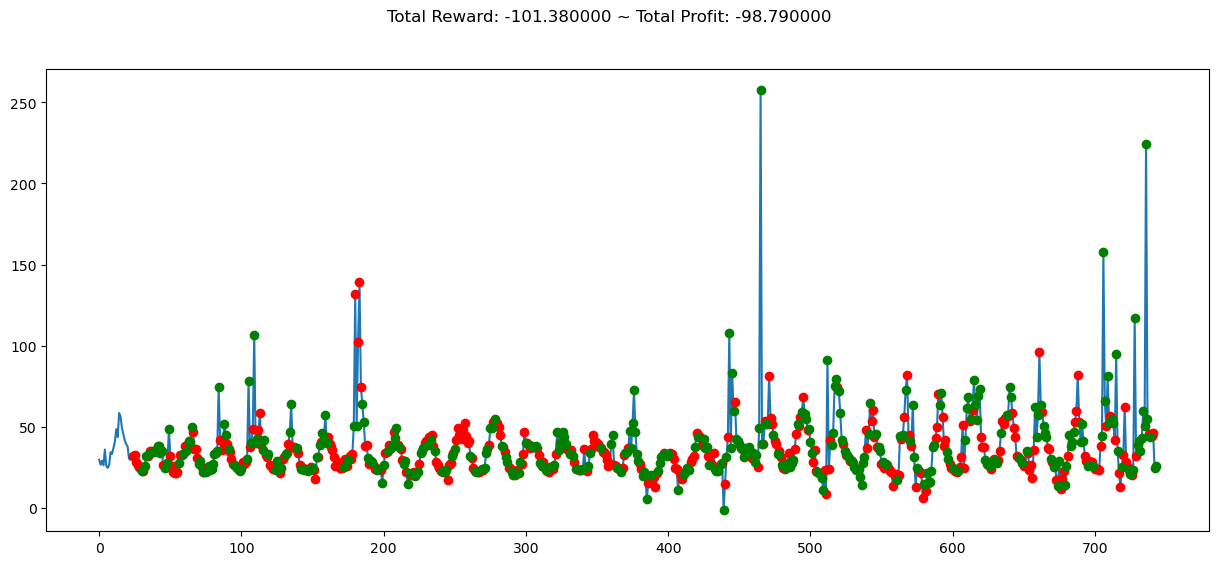

In [31]:
plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()
plt.show()